In [1]:
%matplotlib inline

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

# pytorch
import torch
from torch import optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from collections import OrderedDict

# others
import numpy as np
import pandas as pd

In [2]:
# Multi-layer Perceptron
class DNN(torch.nn.Module):
    def __init__(
        self,
        input_size,
        hidden_size,
        output_size,
        depth
    ):
        super(DNN, self).__init__()
        
        layers = [('input', torch.nn.Linear(input_size, hidden_size))]
        layers.append(('input_activation', torch.nn.Tanh()))
        for i in range(depth): 
            layers.append(
                ('hidden_%d' % i, torch.nn.Linear(hidden_size, hidden_size))
            )
            layers.append(('activation_%d' % i, torch.nn.Tanh()))
        layers.append(('output', torch.nn.Linear(hidden_size, output_size)))

        layerDict = OrderedDict(layers)
        self.layers = torch.nn.Sequential(layerDict)

    def forward(self, x):
        out = self.layers(x)
        return out

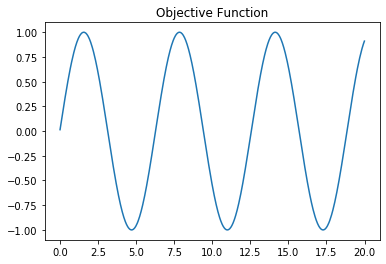

In [3]:
x = torch.empty(2000).uniform_(0, 20)
y = torch.sin(x)
sns.lineplot(x=x, y=y)
plt.title('Objective Function')
plt.show()

In [4]:
device = torch.device('cuda')

trainX = x.view(-1, 1).to(device)
trainY = y.view(-1, 1).to(device)

In [5]:
D_in  = trainX.shape[1]
D_out = trainY.shape[1]
H = 50
Depth = 5
NUMEPOCHS = 3000
Batch_size = int(trainX.shape[0] / 10)

# get training data loader
data_train_loader = DataLoader(
    list(zip(trainX, trainY)), 
    batch_size=Batch_size, 
    shuffle=True
)

print('input dimension =', D_in)
print('output dimension =', D_out)
print('hidden layer size =', H)
print('depth =', Depth)
print('training epochs =', NUMEPOCHS)
print('batch size =', Batch_size)

print('----------------------------------')

input dimension = 1
output dimension = 1
hidden layer size = 50
depth = 5
training epochs = 3000
batch size = 200
----------------------------------


In [6]:
%%time

# Compile model
model = DNN(D_in, H, D_out, Depth).to(device)

# Loss Function
criterion = torch.nn.MSELoss()

# Optimizer
optimizer = optim.Adamax(model.parameters())

CPU times: user 4.24 ms, sys: 55 µs, total: 4.29 ms
Wall time: 4.03 ms


In [7]:
def analytic_loss(inputs, model, res=1e-4):
    left = inputs - res
    right = inputs + res
    grad = torch.cos(inputs).detach() # defined by true derivatives
    outputs = model(inputs)
    y_left = outputs - grad * res
    y_right = outputs + grad * res
    out_left = model(left)
    out_right = model(right)
    loss_left = criterion(out_left, y_left)
    loss_right = criterion(out_right, y_right)
    
    return (loss_left + loss_right) / res

In [8]:
%%time

from tqdm import tqdm

# For Supervising Losses
mse_losses = np.zeros(NUMEPOCHS)
analytic_losses = np.zeros(NUMEPOCHS)

# initial resolution
res = 1e-3

print('epoch', '\t', 'mse_losses', '\t\t', 'analytic_losses', '\t', 'step')

# Train the model
for epoch in range(NUMEPOCHS):
    for batchX, batchY in data_train_loader: 
        # Forward pass
        loss = criterion(model(batchX), batchY)
        
        sample = torch.empty(2000).uniform_(20, 50).view(-1, 1).to(device)
        loss_analytic = analytic_loss(sample, model, res=res) / res
        loss += loss_analytic
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    # update step
#     res *= 0.999
    
    # record the loss history
    mse_losses[epoch] = criterion(model(trainX), trainY).item()
    analytic_losses[epoch] = loss_analytic.item()
    
    if epoch % 100 == 0:
        print(epoch, '\t', mse_losses[epoch], '\t', analytic_losses[epoch], '\t', res)

epoch 	 mse_losses 		 analytic_losses 	 step
0 	 0.44934213161468506 	 0.9968549013137817 	 0.001
100 	 0.3320181369781494 	 0.9758506417274475 	 0.001
200 	 0.13424253463745117 	 0.9557810425758362 	 0.001
300 	 0.0038653300143778324 	 0.9051626324653625 	 0.001
400 	 0.0008413385367020965 	 0.49266040325164795 	 0.001
500 	 0.0005375256878323853 	 0.27632179856300354 	 0.001
600 	 0.005145092029124498 	 0.25510236620903015 	 0.001
700 	 0.004455973394215107 	 0.14297981560230255 	 0.001
800 	 0.002012078883126378 	 0.1060868352651596 	 0.001
900 	 0.00018830357294064015 	 0.057107217609882355 	 0.001
1000 	 0.002569578355178237 	 0.0011828183196485043 	 0.001
1100 	 0.003418013686314225 	 0.013366494327783585 	 0.001
1200 	 8.14987433841452e-05 	 0.0004458422481548041 	 0.001
1300 	 0.0005147376214154065 	 0.0006376025266945362 	 0.001
1400 	 0.0002713366411626339 	 0.00036609178641811013 	 0.001
1500 	 0.004275623243302107 	 0.0003711028548423201 	 0.001
1600 	 0.0017417159397155046

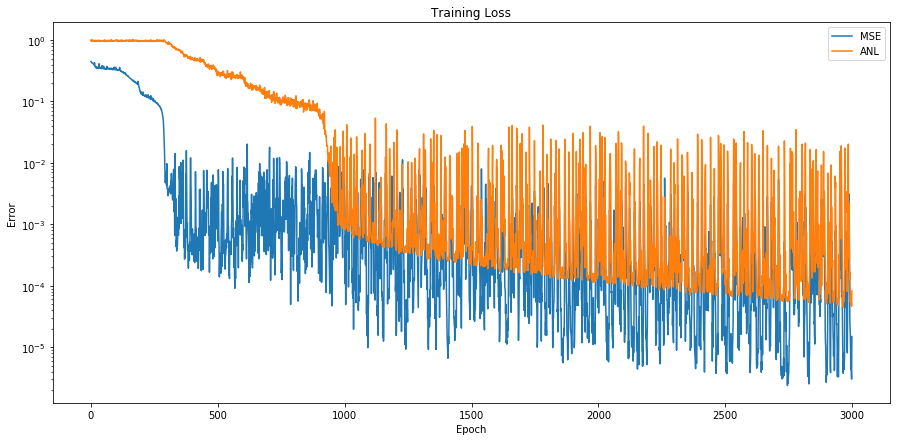

In [16]:
plt.figure(figsize=(15, 7))
sns.lineplot(data=mse_losses, label="MSE")
sns.lineplot(data=analytic_losses, label="ANL")
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.yscale('log')
plt.title('Training Loss')
plt.show()

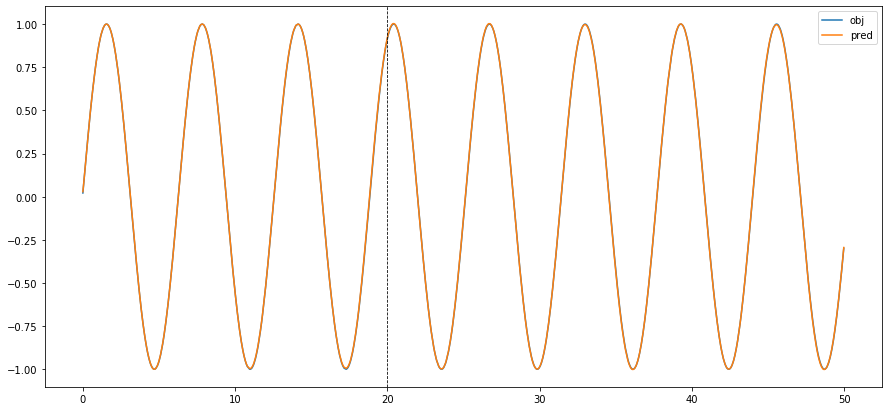

In [17]:
testX = torch.empty(2000).uniform_(0, 50).view(-1, 1).to(device)

test = testX.detach().cpu().numpy().ravel()
pred = model(testX).detach().cpu().numpy().ravel()

plt.figure(figsize=(15, 7))
sns.lineplot(x=test, y=np.sin(test), label='obj')
sns.lineplot(x=test, y=pred, label='pred')

plt.axvline(x=20, color='k', linestyle='--', linewidth=0.8)

plt.show()

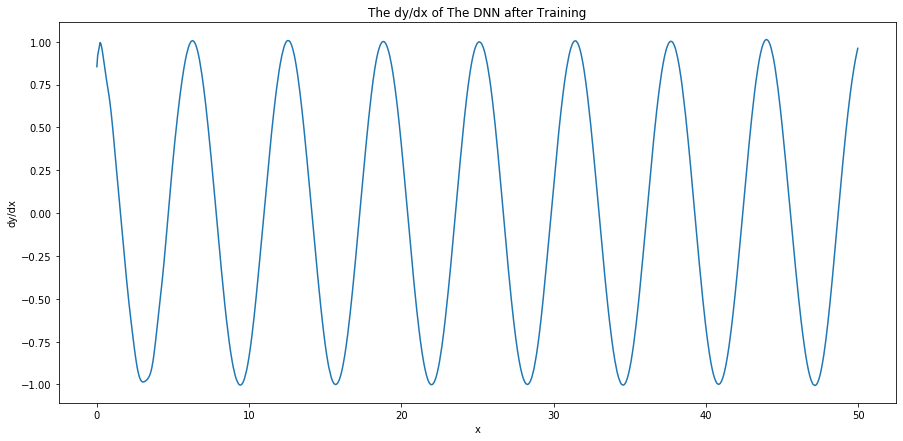

In [18]:
# calculate derivatives using autograd
testX.requires_grad = True
outputs = model(testX)

dy_dx = torch.autograd.grad(
    inputs=testX, 
    outputs=outputs, 
    grad_outputs=torch.ones_like(outputs)
)[0].cpu().numpy()

# plot derivatives
plt.figure(figsize=(15, 7))
sns.lineplot(
    x=testX.detach().cpu().numpy().ravel(), 
    y=dy_dx.ravel()
)
plt.title("The dy/dx of The DNN after Training")
plt.xlabel("x")
plt.ylabel("dy/dx")
plt.show()